### Libraries, functions etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import expit
from scipy.io import arff

import measures
from model import LogReg
from preprocessing import Preprocessor
import experiments

### Loading data

In [2]:
data = arff.loadarff('data/messidor_features.arff')
retinopathy_df = pd.DataFrame(data[0])

X_retinopathy=retinopathy_df.drop(columns='Class')
y_retinopathy=(retinopathy_df['Class'] == b'1').astype(int)

prep_ret = Preprocessor()

In [3]:
X_ret_train, X_ret_test, y_ret_train, y_ret_test = prep_ret.train_test_split(X_retinopathy, y_retinopathy)

In the task requierements we're asked to remove collinear variables, so we're left with only first 4 options. The GD and SGD results for these 4 are very similar (close to 63%). Thats why I would suggest taking the one where the remaining 2 achieve the best results (which in this case is no scaling and no target balancing). The remaining tests will be perfomed in this particular situation.

In [4]:
remove_coll,balance_classes,scaling=True,False,True
X_train=X_ret_train.copy()
X_test=X_ret_test.copy()
y_train=y_ret_train.copy()
y_test=y_ret_test.copy()
if remove_coll:
    X_train = prep_ret.remove_multicollinearity_fit_transform(X_train)
    X_test = prep_ret.remove_multicollinearity_transform(X_test)
if balance_classes:
    X_train,y_train=prep_ret.class_balancing(X_train,y_train)
if scaling:
    s = StandardScaler()
    X_train = s.fit_transform(X_train)
    X_test = s.transform(X_test)
#próbowałem to wrzucić do funkcji preprocess_data, ale coś wywala błąd więc na razie odpuszczam    
    
#One Hot Encoding
#X_train = prep_ret.one_hot_encoding_fit_transform(X_train)
#X_test = prep_ret.one_hot_encoding_transform(X_test)

#X_train=X_train.to_numpy()
y_train=y_train.to_numpy()
#X_test=X_test.to_numpy()
y_test=y_test.to_numpy()

9 numerical features left in dataset  0  categorical


#### 1. Convergence analysis: check how the value of log-likelihood function depends on the number of iterations for 4 above algorithms.

In [5]:
n_epochs=1000

lr_models = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=0.023, epochs=n_epochs, batch_size=32),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=0.00001, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=0.18, beta_1=0.8,
                    beta_2=0.9, epsilon=1e-8)
 }

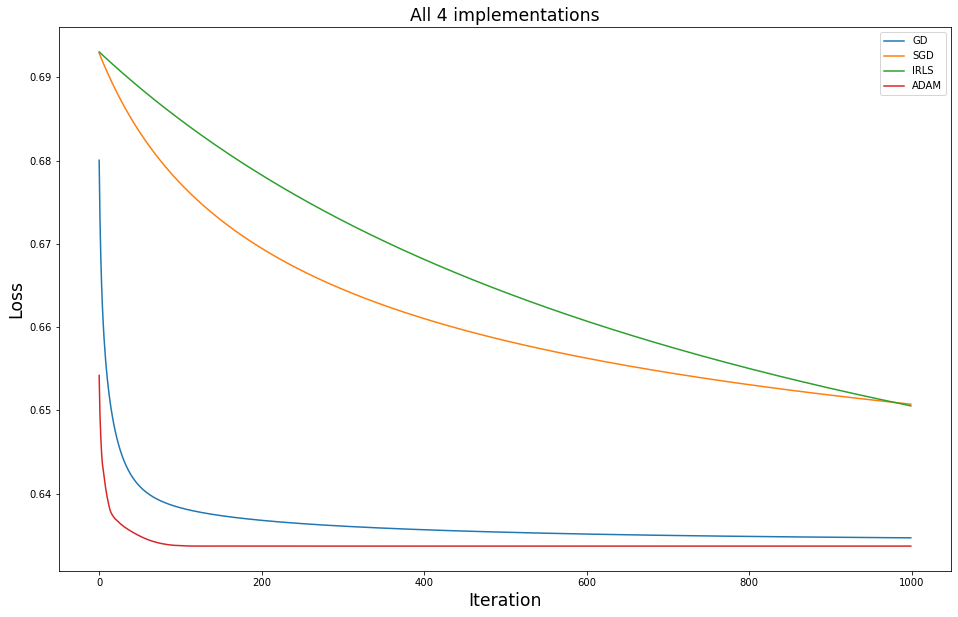

In [6]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models.items():
    model.train(X_train, y_train)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.show()

#### 2. Check how the value of learning rate and other parameters affect the results.

In [7]:
tested_l_rates=np.linspace(start=0.2,stop=1e-5,num=10)
tested_algorithms={'GD': 'Gradient Descent','SGD':'Stochastic Gradient Descent','ADAM':'Adaptive Moment Estimation'}

res_test_learning_rates=experiments.test_learning_rates(X_train,y_train,
                                                        X_test,y_test,
                                                        tested_l_rates,tested_algorithms)
res_test_learning_rates

,learning_rate,method,accuracy,recall,precision,F_measure
0,0.200000,GD,0.587,0.288,0.815,0.425
1,0.200000,SGD,0.545,0.144,1.000,0.251
2,0.200000,ADAM,0.656,0.647,0.688,0.667
3,0.177779,GD,0.590,0.301,0.807,0.438
4,0.177779,SGD,0.542,0.137,1.000,0.241
5,0.177779,ADAM,0.653,0.641,0.685,0.662
6,0.155558,GD,0.611,0.340,0.825,0.481
7,0.155558,SGD,0.542,0.137,1.000,0.241
8,0.155558,ADAM,0.656,0.647,0.688,0.667
9,0.133337,GD,0.625,0.373,0.826,0.514


In [8]:
res_test_learning_rates[res_test_learning_rates['method']=='ADAM'].sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False).head(3)

,learning_rate,method,accuracy,recall,precision,F_measure
20,0.066673,ADAM,0.656,0.654,0.685,0.669
2,0.200000,ADAM,0.656,0.647,0.688,0.667
8,0.155558,ADAM,0.656,0.647,0.688,0.667


In [9]:
tested_betas_1=np.linspace(start=0.75,stop=.95,num=5)
tested_betas_2=np.linspace(start=0.90,stop=0.99,num=10)

res_test_betas=experiments.test_betas(X_train, y_train,
                                      X_test,y_test,
                                      tested_betas_1,tested_betas_2,lr=0.16)
res_test_betas.sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False).head(10)

,beta1,beta2,accuracy,recall,precision,F_measure
6,0.75,0.96,0.670139,0.653595,0.704225,0.677966
0,0.75,0.90,0.666667,0.653595,0.699301,0.675676
1,0.75,0.91,0.666667,0.653595,0.699301,0.675676
2,0.75,0.92,0.666667,0.653595,0.699301,0.675676
3,0.75,0.93,0.666667,0.653595,0.699301,0.675676
4,0.75,0.94,0.666667,0.653595,0.699301,0.675676
5,0.75,0.95,0.666667,0.653595,0.699301,0.675676
10,0.80,0.90,0.666667,0.653595,0.699301,0.675676
11,0.80,0.91,0.666667,0.653595,0.699301,0.675676
12,0.80,0.92,0.666667,0.653595,0.699301,0.675676


#### 4. Compare the classification performance of logistic regression (try all 4 methods: IWLS, GD, SGD and ADAM) and 3 popular classification methods: LDA, QDA and KNN. Use the performance measures implemented in Part 2 and datasets prepared in Part 1. The performance measures should be calculated on test set. If the given algorithm does not converge, within 1000 iterations, stop the algorithm and use the solutions from the last iteration.

In [10]:
lr=0.001
n_epochs=1000
models = {
    'GD': LogReg(optimization='Gradient Descent', learning_rate=0.023, epochs=n_epochs, batch_size=32),
    'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=0.00001, epochs=n_epochs),
    'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
    'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=0.16, beta_1=0.75,
                   beta_2=0.96, epsilon=1e-8),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'LR': LogisticRegression(max_iter=n_epochs),
    'kNN': KNeighborsClassifier()
}

In [11]:
res_final=experiments.final_comparisson(X_train, y_train,
                                        X_test,y_test,
                                        models)
res_final.sort_values(by=['accuracy','f_measure','recall','precision'],ascending=False)

,model,accuracy,recall,precision,f_measure
0,GD,0.680556,0.601307,0.747967,0.666667
3,ADAM,0.666667,0.653595,0.699301,0.675676
6,LR,0.656250,0.653595,0.684932,0.668896
2,IRLS,0.645833,0.660131,0.668874,0.664474
4,LDA,0.638889,0.666667,0.658065,0.662338
1,SGD,0.625000,0.653595,0.645161,0.649351
7,kNN,0.607639,0.666667,0.621951,0.643533
5,QDA,0.593750,0.274510,0.875000,0.417910
